# Front MNIST

In [22]:
# imports
from importlib import reload

import os
import numpy as np

import matplotlib.pyplot as plt

import pandas
import seaborn as sns
import xarray as xr

from skimage import filters as sf

# ulmo -- on f_s branch
from ulmo.llc import kinematics
from ulmo.llc import io as llc_io
from ulmo import io as ulmo_io
from ulmo.plotting import plotting 

from gsw import density

In [2]:
#%matplotlib ipympl

# Load LLC Table (for convenience)

In [3]:
llc_tfile = os.path.join(os.getenv('OS_OGCM'), 'LLC', 'Ulmo', 'Tables', 'LLC_uniform144_r0.5_nonoise.parquet')

In [5]:
llc_u = ulmo_io.load_main_table(llc_tfile)
llc_u.head()

Read main table: /home/xavier/Projects/Oceanography/OGCM/LLC/Ulmo/Tables/LLC_uniform144_r0.5_nonoise.parquet


,lat,lon,row,col,datetime,filename,pp_file,pp_root,field_size,pp_idx,pp_type,mean_temperature,Tmin,Tmax,T90,T10,LL,DT
0,56.752953,-170.447922,11465,10890,2011-09-18,/data/Projects/Oceanography/data/LLC/ThetaUVSa...,s3://llc/PreProc/LLC_uniform144_nonoise_prepro...,llc_144_nonoise,64,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,56.796970,-155.677078,11469,11599,2011-09-18,/data/Projects/Oceanography/data/LLC/ThetaUVSa...,s3://llc/PreProc/LLC_uniform144_nonoise_prepro...,llc_144_nonoise,64,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,56.818966,-155.635422,11471,11601,2011-09-18,/data/Projects/Oceanography/data/LLC/ThetaUVSa...,s3://llc/PreProc/LLC_uniform144_nonoise_prepro...,llc_144_nonoise,64,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,56.631676,-152.864578,11454,11734,2011-09-18,/data/Projects/Oceanography/data/LLC/ThetaUVSa...,s3://llc/PreProc/LLC_uniform144_nonoise_prepro...,llc_144_nonoise,64,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,56.917801,-152.114578,11480,11770,2011-09-18,/data/Projects/Oceanography/data/LLC/ThetaUVSa...,s3://llc/PreProc/LLC_uniform144_nonoise_prepro...,llc_144_nonoise,64,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Grab a cutout in Brazil-Malvanis

In [7]:
llc_u.lon.max()

179.76042

In [8]:
lat_BM = -42.
lon_BM = -50.
d = np.sqrt((llc_u.lat-lat_BM)**2 + (llc_u.lon-lon_BM)**2)
#

In [9]:
srt = np.argsort(d)
# Pick one
idx = srt[50]
# 
cutout = llc_u.iloc[idx].copy()
cutout

lat                                                        -41.811443
lon                                                        -49.572918
row                                                              5488
col                                                             16692
datetime                                          2011-11-13 00:00:00
filename            /data/Projects/Oceanography/data/LLC/ThetaUVSa...
pp_file             s3://llc/PreProc/LLC_uniform144_nonoise_prepro...
pp_root                                               llc_144_nonoise
field_size                                                         64
pp_idx                                                        2275399
pp_type                                                             0
mean_temperature                                            13.979824
Tmin                                                           10.827
Tmax                                                        16.655001
T90                 

In [10]:
cutout.filename = 'LLC4320_2011-09-30T00_00_00.nc'
cutout.filename

'LLC4320_2011-09-30T00_00_00.nc'

## Load dataset

In [11]:
ds = xr.open_dataset(os.path.join(os.getenv('OS_OGCM'), 'LLC', 'data', 'ThetaUVWSaltEta', cutout.filename))

## Grab T,S

In [12]:
cutout.field_size = 64
xoffset = 100
yoffset = 350
#cutout.field_size = 500
#xoffset = 0
#yoffset = 0
row = cutout.row + yoffset
col = cutout.col + xoffset

In [13]:
Theta = ds.Theta[row:row+cutout.field_size, 
                col:col+cutout.field_size].values

In [14]:
Salt = ds.Salt[row:row+cutout.field_size, 
                col:col+cutout.field_size].values

# Front intensity

In [15]:
divb_2 = kinematics.calc_gradb(Theta, Salt)

In [16]:
ii = np.argmax(divb_2)
ii//500

6

## Plot

<Axes: >

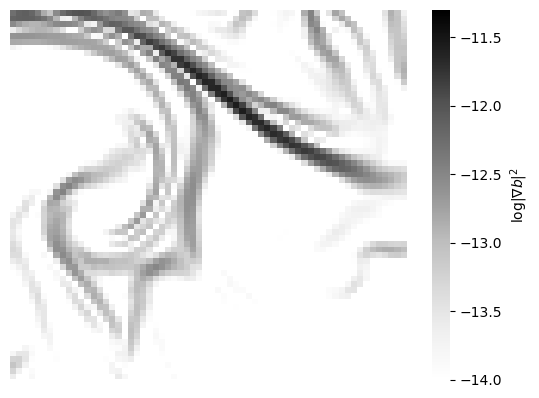

In [51]:
plotting.show_image(np.log10(divb_2), vmnx=(-14., -11.3),
                   clbl=r'$\log |\nabla b|^2$', cm='Greys')

<Axes: >

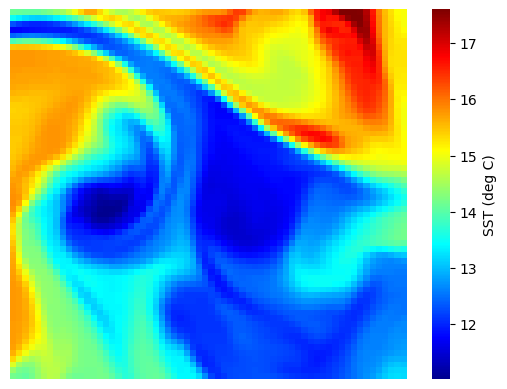

In [45]:
plotting.show_image(Theta, clbl='SST (deg C)')

# Salt (smoothed to 40km)

In [27]:
#
pad = 100
pad_Salt = ds.Salt[row-pad:row+cutout.field_size+pad, 
                col-pad:col+cutout.field_size+pad].values

### Smooth

In [32]:
smooth_salt = sf.gaussian(pad_Salt, 20.)
smooth_salt = smooth_salt[pad:-pad, pad:-pad]
smooth_salt.shape

(64, 64)

<Axes: >

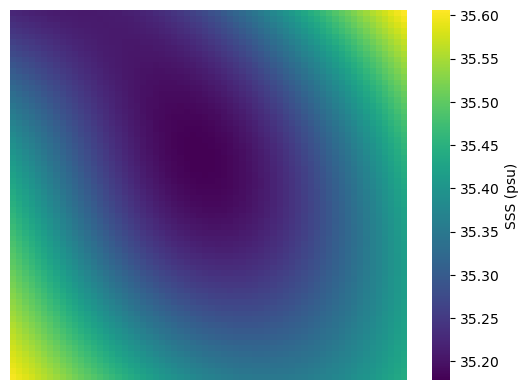

In [57]:
plotting.show_image(smooth_salt, clbl='SSS (psu)', cm='viridis')

# Eta (smoothed to 7km)

In [34]:
pad_eta = ds.Eta[row-pad:row+cutout.field_size+pad, 
                col-pad:col+cutout.field_size+pad].values

In [39]:
smooth_eta = sf.gaussian(pad_eta, 5.)
smooth_eta = smooth_eta[pad:-pad, pad:-pad]

<Axes: >

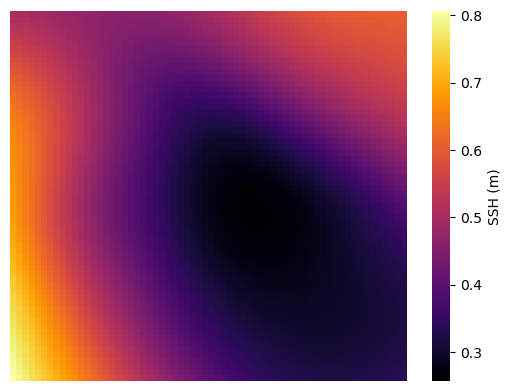

In [56]:
plotting.show_image(smooth_eta, clbl='SSH (m)', cm='inferno')

### No smoothing

In [37]:
eta = ds.Eta[row:row+cutout.field_size, 
                col:col+cutout.field_size].values

<Axes: >

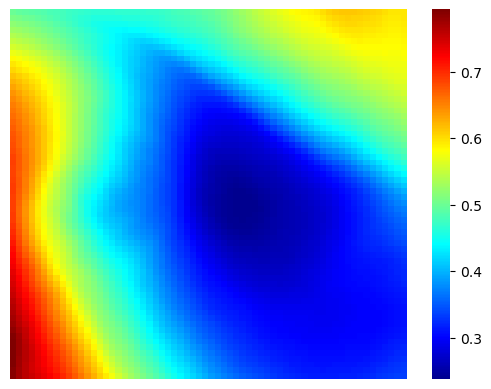

In [38]:
plotting.show_image(eta)

## Density

In [41]:
rho = density.rho(Salt, Theta, np.zeros_like(Salt))

<Axes: >

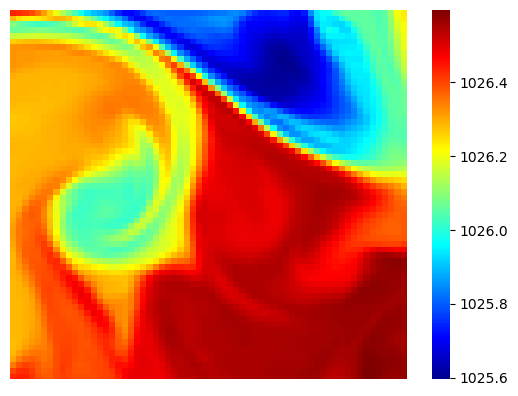

In [42]:
plotting.show_image(rho)

----

In [29]:
rho = density.rho(Salt, Theta, np.zeros_like(Salt))

In [30]:
rho

array([[1026.47388533, 1026.46577767, 1026.44984166, ..., 1026.58379043,
        1026.5930896 , 1026.59635806],
       [1026.4714206 , 1026.45679864, 1026.4312677 , ..., 1026.59288672,
        1026.59890415, 1026.6006586 ],
       [1026.45602867, 1026.43230194, 1026.40570566, ..., 1026.60174436,
        1026.60442318, 1026.60297302],
       ...,
       [1026.37110506, 1026.37077684, 1026.35907003, ..., 1026.31190974,
        1026.30993296, 1026.29968728],
       [1026.37235209, 1026.37143219, 1026.3582314 , ..., 1026.31705655,
        1026.31822415, 1026.31166804],
       [1026.37375403, 1026.37087717, 1026.35912649, ..., 1026.32039697,
        1026.32218232, 1026.31963496]])

In [95]:
ds

<xarray.Dataset>
Dimensions:  (i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_l: 1)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Dimensions without coordinates: k_l
Data variables:
    Theta    (j, i) float32 ...
    U        (j, i_g) float32 ...
    V        (j_g, i) float32 ...
    W        (k_l, j, i) float32 ...
    Salt     (j, i) float32 ...

In [48]:
ds

<xarray.Dataset>
Dimensions:  (i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_l: 1)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Dimensions without coordinates: k_l
Data variables:
    Theta    (j, i) float32 ...
    U        (j, i_g) float32 ...
    V        (j_g, i) float32 ...
    W        (k_l, j, i) float32 ...
    Salt     (j, i) float32 ...
    Eta      (j, i) float32 ...

In [49]:
ds.Eta

<xarray.DataArray 'Eta' (j: 12960, i: 17280)>
[223948800 values with dtype=float32]
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Attributes:
    standard_name:  ETAN
    long_name:      Surface Height Anomaly
    units:          m